In [1]:
import matplotlib.pylab
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from opt_einsum import contract
from tqdm.auto import tqdm
import torch
def _toN(t):
    return t.detach().cpu().numpy()
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [8]:
import importlib
import HOTRGZ2,TNModels,DHOTRG,utils
importlib.reload(HOTRGZ2)
importlib.reload(TNModels)
importlib.reload(DHOTRG)
importlib.reload(utils)
from HOTRGZ2 import HOTRG_layers,forward_observable_tensor,trace_tensor,trace_two_tensors
from DHOTRG import update_isometries
from TNModels import Ising2D

In [9]:
Ising2D.get_default_params()

{'beta': 0.44068679350977147, 'h': 0}

In [10]:
data=pd.DataFrame()
options={
    'nLayers':20,
    'max_dim':6,
    'Z2_projection':False,
    'dHOTRG_inner_iter':1,
    'dHOTRG_iter':1,
}
for beta in tqdm(np.linspace(-.0005,.0005,5)+0.44068679350977147):
    for _iter in tqdm(range(options['dHOTRG_iter']+1),leave=False):
        if _iter==0:
            params={'h':0,'beta':beta}
            model=Ising2D(params)
            isometries,dimRs=HOTRG_layers(model.get_T0(),max_dim=options['max_dim'],nLayers=options['nLayers'],dimR=model.get_dimR())
        else:
            wDiffs,wDiff_inners=update_isometries(model.get_T0(),isometries,dimRs,inner_iter=options['dHOTRG_inner_iter'])
            #print(wDiffs)
            #print(wDiff_inners)
        Ts,T_ops,logTotals=forward_observable_tensor(model.get_T0(),model.get_SZT0(),isometries,dimRs,checkboard=model.observable_checkerboard,return_layers=True)
        for layer in range(len(Ts)):
            T,T_op,logTotal=Ts[layer],T_ops[layer],logTotals[layer]
            logZ=_toN((torch.log(trace_tensor(T))+logTotal)/2**layer)
            magnetization1=_toN(torch.abs(trace_tensor(T_op)/trace_tensor(T)))
            magnetization=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
            newRow={**params,
                    **options,
                    'iter':_iter,'layer':layer,
                    'logZ':logZ,'magnetization':magnetization,'magnetization1':magnetization1}
            if layer==len(Ts)-1:
                pass
                #print(newRow)
            data=data.append(newRow,ignore_index=True)
data.to_pickle('IsingSRG.pkl')
        

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

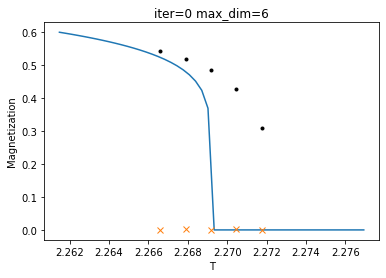

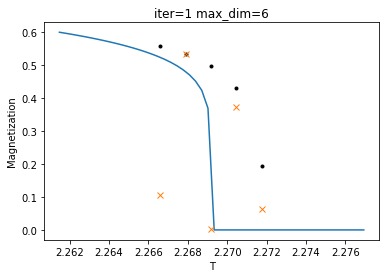

In [11]:

import IsingSolutions
importlib.reload(IsingSolutions)
from IsingSolutions import Ising2DExactSolution

nLayers=int(max(data['layer']))

def relerr(x,ref):
    return abs(x-ref)/abs(ref)

def abserr(x,ref):
    return abs(x-ref)

for _iter in [0,int(max(data['iter']))]:
    ls=np.linspace(min(data['beta'])-.001,max(data['beta'])+.001)
    plt.plot(1/ls,Ising2DExactSolution().magnetization(ls))
    data1=data[(data['layer']==nLayers) & (data['iter']==_iter)]
    plt.plot(1/data1['beta'],data1['magnetization'],'.',color='black')
    plt.plot(1/data1['beta'],data1['magnetization1'],'x')
    plt.xlabel('T')
    plt.ylabel('Magnetization')
    plt.title(f'iter={_iter} max_dim={options["max_dim"]}')
    plt.show()
    
    #plt.plot(1/data1['beta'],abserr(data1['magnetization'],Ising2DExactSolution().magnetization(data1['beta'])),'.-',color='black')
    #plt.xlabel('T')
    #plt.ylabel('Magnetization abserr')
    #plt.yscale('log')
    #plt.title(f'iter={_iter} max_dim={options["max_dim"]}')
    #plt.show()
    #
    #plt.plot(1/data1['beta'],relerr(data1['logZ'],Ising2DExactSolution().logZ(data1['beta'])),'.-',color='black')
    #plt.xlabel('T')
    #plt.ylabel('logZ relerr')
    #plt.yscale('log')
    #plt.title(f'iter={_iter} max_dim={options["max_dim"]}')
    #plt.show()

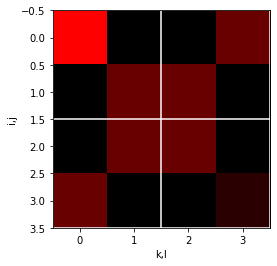

In [6]:
from utils import show_tensor_ijkl

show_tensor_ijkl(_toN(Ising2D().get_T0()))

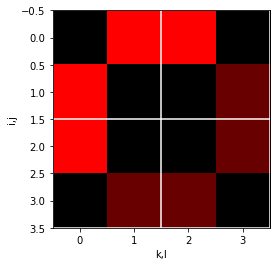

In [7]:
show_tensor_ijkl(_toN(Ising2D().get_SZT0()))

In [31]:
beta=ls


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.30759786,
       0.36441171, 0.39059478, 0.4083066 , 0.42186223, 0.43291575,
       0.44228626, 0.45044208, 0.45767727, 0.46418911, 0.47011663,
       0.47556166, 0.48060114, 0.48529463, 0.48968927, 0.493823  ])

  0%|          | 0/20 [00:00<?, ?it/s]

0.21395919 0.0
6 6 6 6


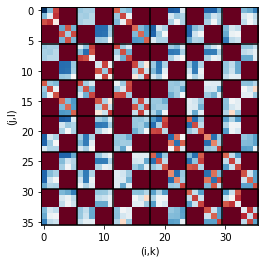

0 [1, 1] [2, 2]


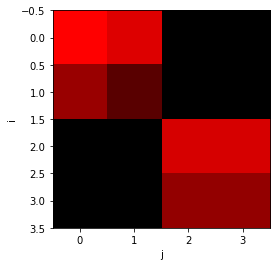

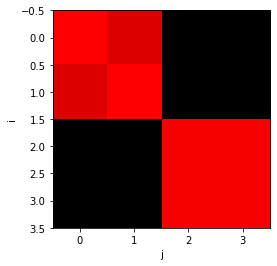

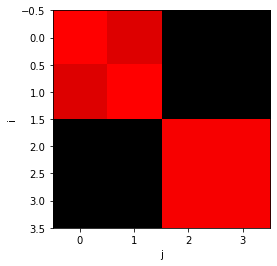

1 [1, 1] [2, 2]


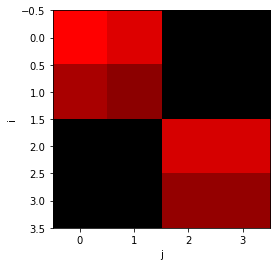

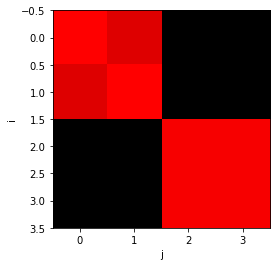

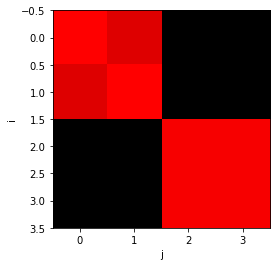

2 [2, 2] [3, 3]


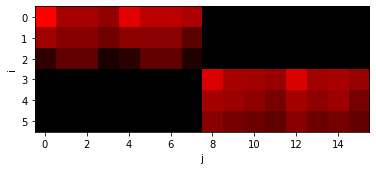

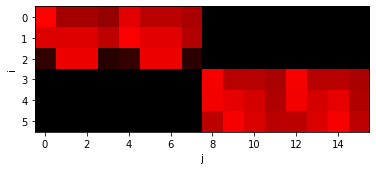

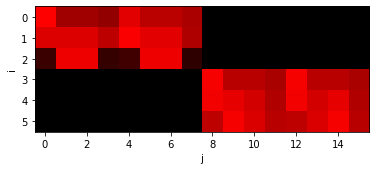

3 [2, 2] [3, 3]


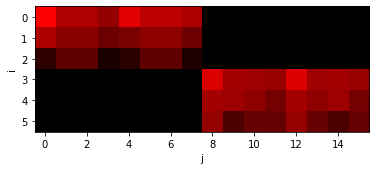

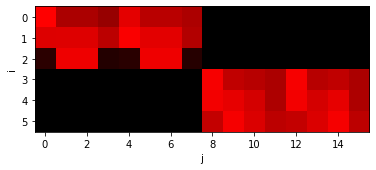

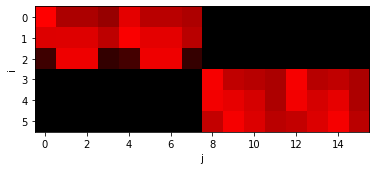

4 [3, 3] [3, 3]


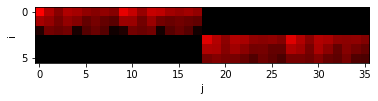

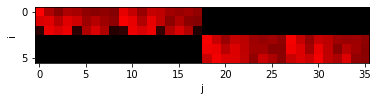

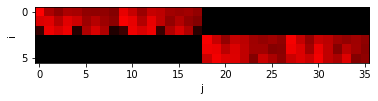

5 [3, 3] [3, 3]


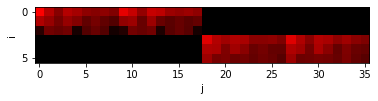

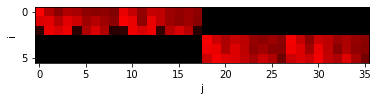

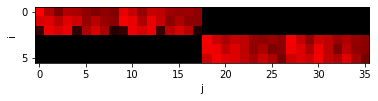

6 [3, 3] [3, 3]


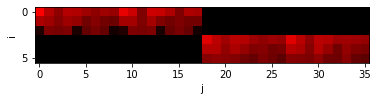

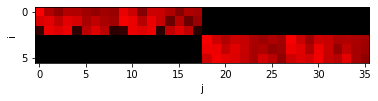

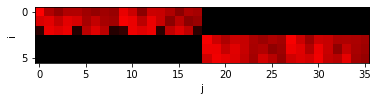

7 [3, 3] [3, 3]


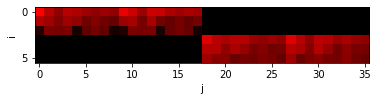

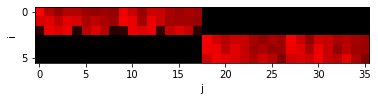

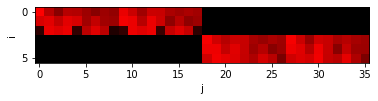

8 [3, 3] [3, 3]


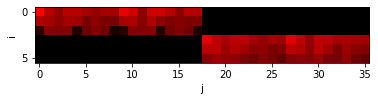

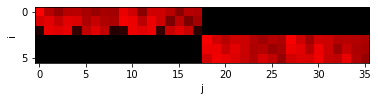

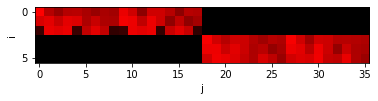

9 [3, 3] [3, 3]


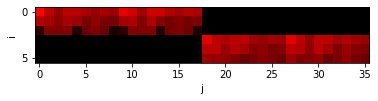

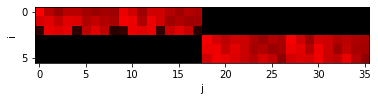

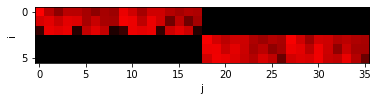

10 [3, 3] [3, 3]


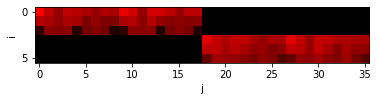

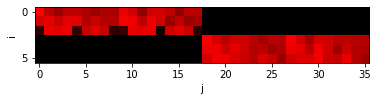

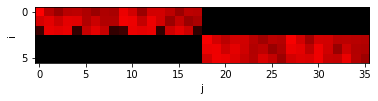

11 [3, 3] [3, 3]


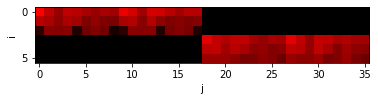

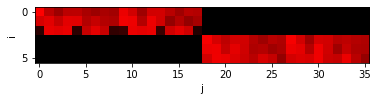

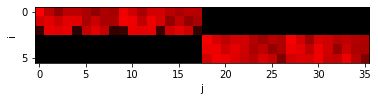

12 [3, 3] [3, 3]


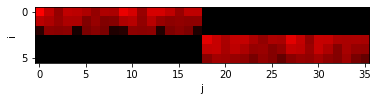

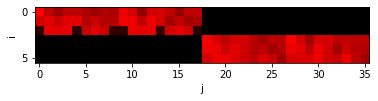

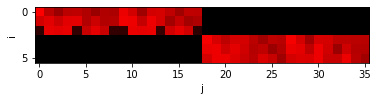

13 [3, 3] [3, 3]


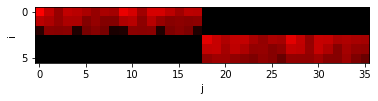

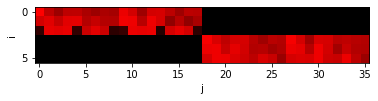

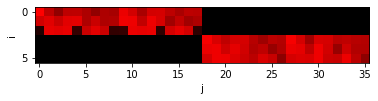

14 [3, 3] [3, 3]


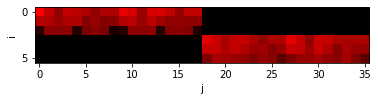

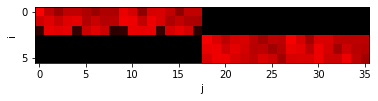

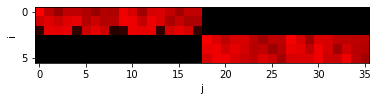

15 [3, 3] [3, 3]


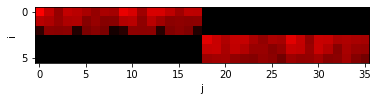

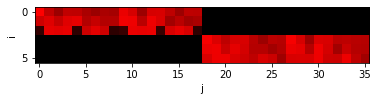

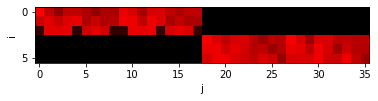

16 [3, 3] [3, 3]


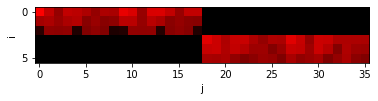

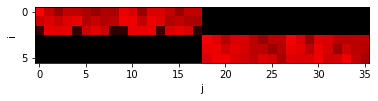

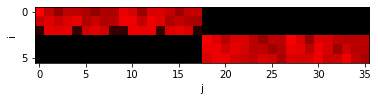

17 [3, 3] [3, 3]


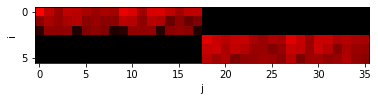

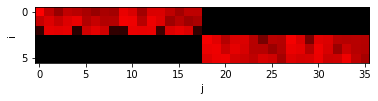

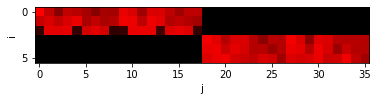

18 [3, 3] [3, 3]


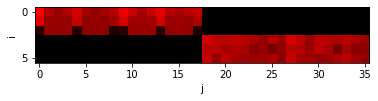

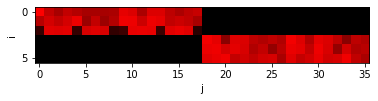

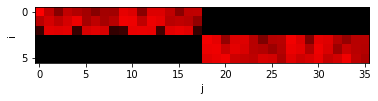

19 [3, 3] [3, 3]


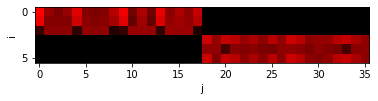

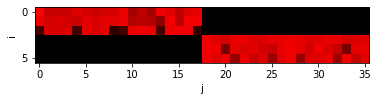

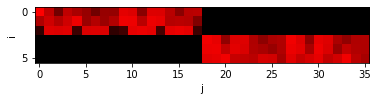

In [389]:
options={
    'nLayers':20,
    'max_dim':6,
    'Z2':True,
}
params={'h':0,'beta':.44}
model=Ising2D(params)
isometries,dimRs=calc_isometries(model.get_T0(),model.get_dimR(Z2=options['Z2']),max_dim=options['max_dim'],nLayers=options['nLayers'])

T,T_op,logTotals=forward_observable_tensor(model.get_T0(),model.get_SZT0(),isometries,dimRs,checkboard=model.observable_checkerboard,return_layers=False)
magnetization=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
magnetization1=_toN(torch.abs(trace_tensor(T_op)/trace_tensor(T)))
print(magnetization,magnetization1)
show_tensor(T.detach().abs()**.1);plt.show()

for layer in range(options['nLayers']):
    print(layer,dimRs[layer][1],dimRs[layer+1][0])
    E=calc_environment_tensor(model.get_T0(),isometries,dimRs,layer,0)
    w=get_isometry_from_environment_tensor(E,dimRs[layer][1],dimRs[layer+1][0])
    show_matrix(E.detach().abs()**.1);plt.show()
    show_matrix(w.detach().abs()**.1);plt.show()
    show_matrix(isometries[layer][0].detach().abs()**.1);plt.show()

#for i in range(1):
#    update_isometries(model.get_T0(),isometries,dimRs)
#    T,T_op,logTotals=forward_observable_tensor(model.get_T0(),model.get_SZT0(),isometries,dimRs,checkboard=model.observable_checkerboard,return_layers=False)
#magnetization=_toN((trace_two_tensors(T_op)/trace_two_tensors(T))**.5)
#magnetization1=_toN(torch.abs(trace_tensor(T_op)/trace_tensor(T)))
#E=DHOTRG.calc_environment_tensor(model.get_T0(),isometries,dimRs,19,0)
#w=DHOTRG.get_isometry_from_environment_tensor(E,dimRs[19][1],dimRs[20][0])
#print(magnetization,magnetization1)
#myutils.show_tensor(T.detach().abs()**.1);plt.show()
#myutils.show_matrix(isometries[-1][0].detach().abs()**.1);plt.show()
#myutils.show_matrix(E.detach().abs()**.1);plt.show()
#myutils.show_matrix(w.detach().abs()**.1);plt.show()
